In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ujunwajoyclyn","key":"79c16f86139b203558ee709892563458"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download nikitarom/planets-dataset

 99% 1.49G/1.50G [00:25<00:00, 88.9MB/s]
100% 1.50G/1.50G [00:25<00:00, 63.7MB/s]


In [6]:
!unzip planets-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: test-jpg-additional/test-jpg-additional/file_5499.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_55.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_550.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5500.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5501.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5502.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5503.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5504.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5505.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5506.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5507.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5508.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5509.jpg  
  inflating: test-jpg-additional/test-jpg-additional/fi

In [7]:
import numpy as np
import pandas as pd


In [8]:
train_classes = pd.read_csv('/content/planet/planet/train_classes.csv', dtype = str)
sample_sub = pd.read_csv('/content/planet/planet/sample_submission.csv', dtype = str)

In [9]:
tag_labels = train_classes['tags'].map(lambda x: x.split(" "))
splitted_tags = tag_labels.values
labels = list(set([y for x in splitted_tags for y in x]))

In [10]:
import cv2

In [11]:
len(labels)

17

In [12]:
label_map = {'agriculture': 0,
 'artisinal_mine': 1,
 'bare_ground': 2,
 'blooming': 3,
 'blow_down': 4,
 'clear': 5,
 'cloudy': 6,
 'conventional_mine': 7,
 'cultivation': 8,
 'habitation': 9,
 'haze': 10,
 'partly_cloudy': 11,
 'primary': 12,
 'road': 13,
 'selective_logging': 14,
 'slash_burn': 15,
 'water': 16}

In [13]:
def load_data(train_classes, Labels, new_size):
  X_train = []
  y_train = []
  label_map = {l: i for i, l in enumerate(Labels)}
  inv_label_map = {i: l for l, i in label_map.items()}
  for f, tags in train_classes.values:
    img = cv2.imread('/content/planet/planet/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
      targets[label_map[t]] = 1
    X_train.append(cv2.resize(img, new_size, interpolation = cv2.INTER_CUBIC))
    y_train.append(targets)
  y_train = np.array(y_train, np.uint8)
  X_train = np.array(X_train, np.float32) / 255.

  return X_train, y_train


In [14]:
X, Y = load_data(train_classes, labels, new_size = (32, 32))

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.3)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense,Dropout

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(518, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(17, activation='sigmoid'))

In [18]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [19]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs = 60, batch_size=64)

Epoch 1/60
443/443 [==============================] - 23s 50ms/step - loss: 0.2461 - accuracy: 0.7526 - val_loss: 0.2141 - val_accuracy: 0.7760
Epoch 2/60
443/443 [==============================] - 23s 53ms/step - loss: 0.2053 - accuracy: 0.7622 - val_loss: 0.2018 - val_accuracy: 0.7600
Epoch 3/60
443/443 [==============================] - 22s 51ms/step - loss: 0.1948 - accuracy: 0.7571 - val_loss: 0.1936 - val_accuracy: 0.7335
Epoch 4/60
443/443 [==============================] - 22s 49ms/step - loss: 0.1842 - accuracy: 0.7489 - val_loss: 0.1827 - val_accuracy: 0.7392
Epoch 5/60
443/443 [==============================] - 22s 49ms/step - loss: 0.1755 - accuracy: 0.7418 - val_loss: 0.1796 - val_accuracy: 0.7025
Epoch 6/60
443/443 [==============================] - 22s 49ms/step - loss: 0.1702 - accuracy: 0.7421 - val_loss: 0.1681 - val_accuracy: 0.7377
Epoch 7/60
443/443 [==============================] - 22s 49ms/step - loss: 0.1644 - accuracy: 0.7361 - val_loss: 0.1637 - val_accuracy:

Text(0.5, 1.0, 'Loss Curves')

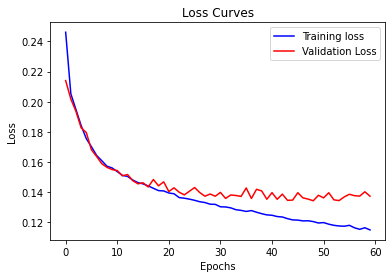

In [20]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], 'blue')
plt.plot(history.history['val_loss'], 'red')
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')

In [22]:
from tqdm import tqdm

In [24]:
X_test=[]

for img, label in tqdm(sample_sub[:40669].values, miniters = 1000):
  X_test.append(cv2.resize(cv2.imread('/content/planet/planet/test-jpg/{}.jpg'.format(img)), (32,32)))

for img, label in tqdm(sample_sub[40669:].values, miniters = 1000):
  X_test.append(cv2.resize(cv2.imread('/content/test-jpg-additional/test-jpg-additional/{}.jpg'.format(img)), (32,32)))

x_test = np.array(X_test, np.float32)/255

100%|██████████| 20522/20522 [00:22<00:00, 924.65it/s]


In [25]:
Test_Predictions = model.predict(x_test, batch_size = 64)

In [27]:
Prediction_df = pd.DataFrame(Test_Predictions, columns= labels)
Prediction_df

,water,primary,cloudy,partly_cloudy,bare_ground,cultivation,artisinal_mine,haze,slash_burn,blow_down,agriculture,conventional_mine,clear,habitation,blooming,selective_logging,road
0,0.032562,0.999857,8.476507e-06,0.000706,5.958378e-04,0.005087,5.444324e-09,1.309305e-03,1.261401e-05,1.357883e-03,0.022176,8.795212e-08,9.987417e-01,0.001943,9.292543e-03,1.710534e-03,0.012672
1,0.080582,0.999997,1.088392e-07,0.000243,1.499951e-03,0.053778,4.671558e-07,8.571630e-05,8.966029e-04,1.733887e-02,0.142388,5.795122e-07,9.998496e-01,0.018827,2.799535e-02,2.471963e-02,0.141160
2,0.041596,1.000000,1.197938e-07,0.999999,4.383412e-05,0.014717,2.086264e-07,2.101008e-13,5.784016e-06,9.451493e-06,0.074275,2.306729e-08,2.407739e-09,0.001127,2.080248e-07,1.876955e-06,0.024155
3,0.120941,0.998921,1.011029e-04,0.049984,8.209169e-03,0.082010,1.175570e-06,7.753968e-03,1.765519e-03,5.806774e-03,0.192089,2.976936e-06,9.191033e-01,0.011211,2.092478e-02,8.615136e-03,0.059549
4,0.154189,0.954467,2.325425e-02,0.990395,3.813803e-04,0.076472,5.270021e-05,7.813956e-05,1.073301e-03,1.216605e-06,0.280299,2.251684e-05,4.531610e-05,0.023071,1.669659e-05,2.159222e-05,0.203011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61186,0.062880,0.407156,6.292325e-01,0.491528,6.833322e-06,0.004889,1.884748e-09,7.201433e-04,2.111707e-09,1.492049e-11,0.075004,1.526815e-10,1.586676e-04,0.005759,1.625269e-09,2.176403e-08,0.067466
61187,0.864199,0.995661,9.219801e-06,0.008713,6.485289e-02,0.120500,3.668922e-02,3.034115e-03,2.030313e-03,1.696680e-07,0.188747,1.463473e-03,9.780253e-01,0.080672,1.088679e-03,6.742239e-03,0.184865
61188,0.058876,0.999975,3.117090e-06,0.013453,8.575618e-04,0.037678,7.347693e-08,5.393326e-04,6.052852e-04,5.093336e-03,0.049085,7.234233e-08,9.885992e-01,0.004351,2.645922e-02,1.232123e-02,0.046861
61189,0.026545,0.176750,8.117783e-01,0.000013,3.939437e-09,0.000172,3.925627e-13,2.188177e-01,5.897165e-14,1.079733e-11,0.002357,8.787648e-12,1.626521e-03,0.000412,2.283556e-10,1.710407e-08,0.003925


In [30]:
final_prediction = []

for i in tqdm(range(Prediction_df.shape[0]), miniters=1000):
    a = Prediction_df.loc[[i]]
    a = a.apply(lambda x:x>0.2, axis =1)
    a = a.transpose()
    a = a.loc[a[i]==True]
    ' '.join(list(a.index))
    final_prediction.append(' '.join(list(a.index)))

100%|██████████| 61191/61191 [01:43<00:00, 591.70it/s]


In [31]:
sample_sub['tags'] = final_prediction
sample_sub.to_csv('new_sampe_submission.csv', index = False)